In [44]:
from __future__ import absolute_import
from __future__ import print_function
import os


import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Merge, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization

import matplotlib.pyplot as plt

from keras import backend as K
from keras.applications import imagenet_utils


from skimage.io import imread

import cv2
import numpy as np
import json

%matplotlib inline

In [2]:
!ls

CamVid                    data_road.zip             segnet_small_keras.ipynb
Train                     eds_data_analysis.ipynb   vgg
Untitled.ipynb            label.csv                 vgg.zip
data_road                 lyft_training_data.tar.gz


## load image and label data

In [3]:
import glob
import seaborn as sns
import pandas as pd

In [6]:
data_shape = 360*480 # fix size for train and annot image 


SampleDataDir = "CamVid"
trainannot = "trainannot"
train_txt = "train.txt"

train_data = os.path.join(SampleDataDir, train_txt)

df = pd.read_csv(train_data,sep="\s+", names=["image","label"])

In [16]:
df.head()

,image,label
0,/SegNet/CamVid/train/0001TP_006690.png,/SegNet/CamVid/trainannot/0001TP_006690.png
1,/SegNet/CamVid/train/0001TP_006720.png,/SegNet/CamVid/trainannot/0001TP_006720.png
2,/SegNet/CamVid/train/0001TP_006750.png,/SegNet/CamVid/trainannot/0001TP_006750.png
3,/SegNet/CamVid/train/0001TP_006780.png,/SegNet/CamVid/trainannot/0001TP_006780.png
4,/SegNet/CamVid/train/0001TP_006810.png,/SegNet/CamVid/trainannot/0001TP_006810.png


In [22]:
split_ops = lambda x:x.split("/")[-1]
image_files = df["image"].apply(split_ops).tolist()
label_files = df["label"].apply(split_ops).tolist()

image_ops = lambda x:imread(x)
traindir_ops = lambda x:os.path.join(SampleDataDir+"/"+"train",x)
trainannotdir_ops = lambda x:os.path.join(SampleDataDir+"/"+"trainannot",x)

images =    list(  map( image_ops,    list(map(  traindir_ops, image_files)) ) )
labels =    list(  map( image_ops,    list(map(  trainannotdir_ops, label_files)) ) )


## another way to unpack labels

In [36]:
def one_hot_it(labels):
    x = np.zeros([360,480,12])
    for i in range(360):
        for j in range(480):
            x[i,j,labels[i][j]] = 1
    return x


with open(train_data) as f:
    txt = f.readlines()
    txt = [line.split(' ') for line in txt]

label = []    
for i in range(len(txt)):
    label.append(one_hot_it(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0]))
    

In [68]:
labels_array = np.array(labels)
l,h,w = labels_array.shape

new_labels = np.zeros([l,h,w,12])
print(new_labels.shape)

for i in range(l):
    for j in range(12):
        
        bins = np.zeros_like( labels[i])
        bins[ labels[i] == j ] = 1
        new_labels[i,:,:,j] = bins
        

(367, 360, 480, 12)


In [39]:
def label_visualize(label):
    for i in range(12):
        im = label[:,:,i]
        plt.imshow(im)
        plt.show()

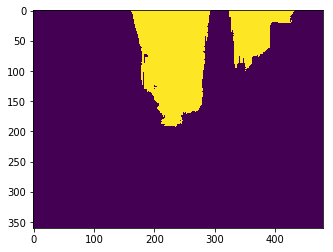

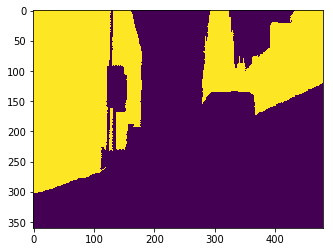

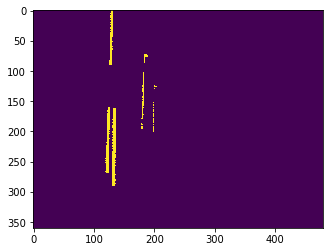

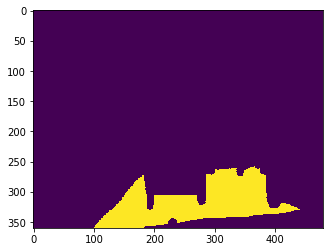

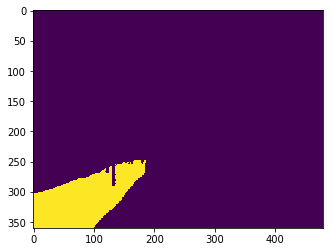

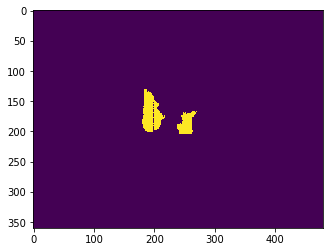

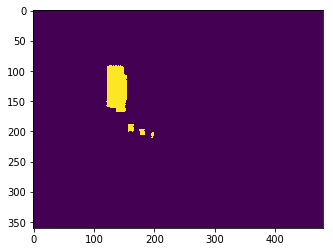

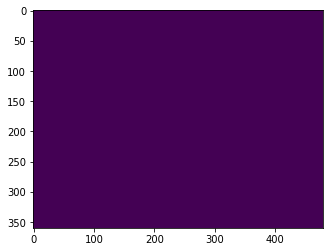

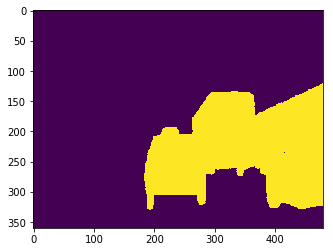

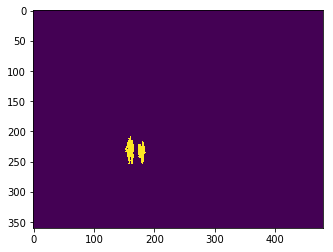

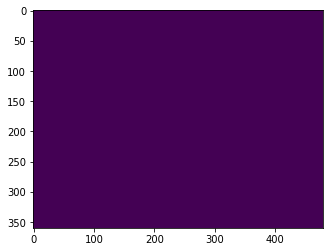

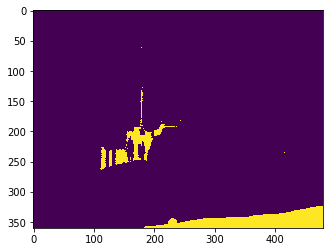

In [40]:
label_visualize(label[0])

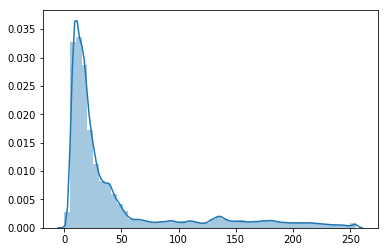

In [41]:
sns.distplot(images[0].ravel())

In [56]:
def normalized(rgb):
    #return rgb/255.0
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    r=rgb[:,:,0]
    g=rgb[:,:,1]
    b=rgb[:,:,2]

    norm[:,:,0]=cv2.equalizeHist(r)
    norm[:,:,1]=cv2.equalizeHist(g)
    norm[:,:,2]=cv2.equalizeHist(b)

    return norm

normalized_ops = lambda x:normalized(x)

In [61]:
norm_images = list(  map(  normalized_ops,  images    )  )
norm_images = np.array(norm_images)

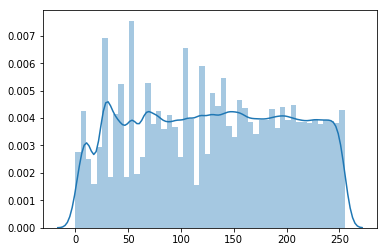

In [62]:
sns.distplot(norm_images[0].ravel())

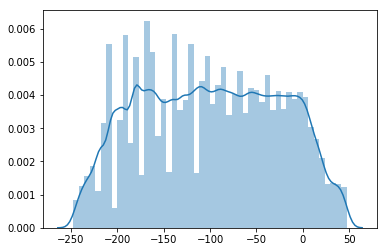

In [64]:
x = imagenet_utils.preprocess_input(norm_images)
sns.distplot(x[0].ravel())

In [67]:
plt.imshow(x[0])

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11c1da400> (for post_execute):


ValueError: Floating point image RGB values must be in the 0..1 range.

ValueError: Floating point image RGB values must be in the 0..1 range.

## Calculate Class Weights 

In [42]:
from sklearn.utils import class_weight

unique, counts = np.unique( y_train, return_counts=True )
dict(zip( unique, counts ))

{0: 10682767,
 1: 14750079,
 2: 623349,
 3: 20076880,
 4: 2845085,
 5: 6166762,
 6: 743859,
 7: 714595,
 8: 3719877,
 9: 405385,
 10: 184967,
 11: 2503995}

In [44]:
y_train = np.array(annot_images).ravel()
print(np.unique(y_train))
class_weight_list = class_weight.compute_class_weight("balanced",
                                                 np.unique(y_train),
                                                 y_train)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [45]:
len(y_train)  / ( np.bincount( y_train) * 12 )

array([ 0.49470329,  0.35828961,  8.47807568,  0.26322815,  1.8575192 ,
        0.85698135,  7.10457224,  7.39551774,  1.42069214, 13.03649617,
       28.57158304,  2.11054735])

In [46]:
print(class_weight_list)

#class_weighting = [0.2595, 0.1826, 4.5640, 0.1417, 0.5051, 0.3826, 9.6446, 1.8418, 6.6823, 6.2478, 3.0, 7.3614]

[ 0.49470329  0.35828961  8.47807568  0.26322815  1.8575192   0.85698135
  7.10457224  7.39551774  1.42069214 13.03649617 28.57158304  2.11054735]


In [ ]:
def generate_train_batch(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data)-2000)
            name_str,img,bb_boxes = get_image_name(df_vehicles,i_line,
                                                   size=(img_cols, img_rows),
                                                  augmentation=True,
                                                   trans_range=50,
                                                   scale_range=50
                                                  )
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks

In [69]:
range(0, l, 16)

range(0, 367, 16)

In [ ]:
height = 360
width = 480
classes = 12
epochs = 100
batch_size = 1
log_filepath='./logs_100/'

data_shape = 360*480

def writeImage(image, filename):
    """ label data to colored image """
    Sky = [128,128,128]
    Building = [128,0,0]
    Pole = [192,192,128]
    Road_marking = [255,69,0]
    Road = [128,64,128]
    Pavement = [60,40,222]
    Tree = [128,128,0]
    SignSymbol = [192,128,128]
    Fence = [64,64,128]
    Car = [64,0,128]
    Pedestrian = [64,64,0]
    Bicyclist = [0,128,192]
    Unlabelled = [0,0,0]
    r = image.copy()
    g = image.copy()
    b = image.copy()
    label_colours = np.array([Sky, Building, Pole, Road_marking, Road, Pavement, Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])
    for l in range(0,12):
        r[image==l] = label_colours[l,0]
        g[image==l] = label_colours[l,1]
        b[image==l] = label_colours[l,2]
    rgb = np.zeros((image.shape[0], image.shape[1], 3))
    rgb[:,:,0] = r/1.0
    rgb[:,:,1] = g/1.0
    rgb[:,:,2] = b/1.0
    im = Image.fromarray(np.uint8(rgb))
    im.save(filename)

def predict(test):
    model = keras.models.load_model('seg_100.h5')
    probs = model.predict(test, batch_size=1)

    prob = probs[0].reshape((height, width, classes)).argmax(axis=2)
    return prob

def main():
    print("loading data...")
    ds = dataset.Dataset(test_file='val.txt', classes=classes)
    test_X, test_y = ds.load_data('test') # need to implement, y shape is (None, 360, 480, classes)
    test_X = ds.preprocess_inputs(test_X)
    test_Y = ds.reshape_labels(test_y)

    prob = predict(test_X)
    writeImage(prob, 'val.png')